In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
#os.environ["CUDA_VISIBLE_DEVICES"]=""
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"

import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

from i3cols_dataloader import load_events

import matplotlib.animation as animation

import gc

from tqdm import tqdm

import dragoman as dm
from dragoman.utils.stats import weighted_quantile

from likelihood import LLH

%load_ext line_profiler

In [2]:
from retro_likelihood import retroLLH

In [3]:
plt.rcParams['figure.figsize'] = [12., 8.]
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14 
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['legend.fontsize'] = 14

# Test NNs
Using an independent MC file

In [2]:
events, labels = load_events(dir='/home/iwsatlas1/peller/work/oscNext/level7_v01.04/140000_i3cols_test')

In [27]:
freedom_llh = LLH(hitnet_file='models/HitNet_logE18_May_2020-21h02/epoch_32_model.hdf5',
          chargenet_file='models/ChargeNet_logE_18_May_2020-21h03/epoch_400_model.hdf5',
          epsilon=1e-7,
         )

In [6]:
retro_llh = retroLLH()

Instantiating and loading DOM tables
These DOMs will be disabled and return 0's for expected photon computations. 5072 DOMs remain.
failed to find "/home/iwsatlas1/peller/work/retro_tables/SpiceLea/tilt_on_anisotropy_on_noazimuth_ic80_dc60_histats/cl140" (this may inidicate that all existing tables are loaded)

  -> 28.664 s

dom_tables.shape: (140, 80, 40, 100)
dom_table_norms.shape: (140, 80, 100)
t_indep_dom_tables.shape: (140, 80, 40, 40, 40)
t_indep_dom_table_norms.shape: (140, 80)
track_kernel: table_energy_loss


In [5]:
def get_llh_2d(event, plot_dim_x, plot_dim_y, n_steps=100, width='tight', subtract=True, do_retro=True):
    plot_idx_x = labels.index(plot_dim_x)
    true_p_x = event['params'][plot_idx_x]
    plot_idx_y = labels.index(plot_dim_y)
    true_p_y = event['params'][plot_idx_y]
    
    if width == 'tight':
        delta_x = 50
        delta_y = 50
        logE = 2
    elif width == 'super_wide':
        delta_x = 2000
        delta_y = 2000
        logE = 6
    else:
        delta_x = 500
        delta_y = 500
        logE = 3

    if plot_dim_x == 'zenith':
        xs = np.linspace(0, np.pi, n_steps)
    elif plot_dim_x == 'azimuth':
        xs = np.linspace(true_p_x - np.pi, true_p_x + np.pi, n_steps)
    elif 'energy' in plot_dim_x:
        xs = np.logspace(0,logE, n_steps)
        #xs = np.linspace(0, min(max(10, 10*true_p_x), 1000), n_steps)
    else:
        if plot_dim_x == 'time':
            delta_x *= 5
        xs = np.linspace(true_p_x-delta_x, true_p_x+delta_x, n_steps)

        
    if plot_dim_y == 'zenith':
        ys = np.linspace(0, np.pi, n_steps)
    elif plot_dim_y == 'azimuth':
        ys = np.linspace(true_p_y - np.pi, true_p_y + np.pi, n_steps)
    elif 'energy' in plot_dim_y:
        ys = np.logspace(0,logE, n_steps)
        #ys = np.linspace(0, min(max(10, 10*true_p_y), 1000), n_steps)
    else:
        if plot_dim_y == 'time':
            delta_y *= 5
        ys = np.linspace(true_p_y-delta_y, true_p_y+delta_y, n_steps)    

    p = dm.GridData(**{plot_dim_x:xs, plot_dim_y:ys})
    
    params = np.repeat(event['params'][np.newaxis, :], repeats=p.grid.size, axis=0)
    params[:, plot_idx_x] = p[plot_dim_x].flatten()
    params[:, plot_idx_y] = p[plot_dim_y].flatten()
    
    
    total_llh, q_llh, all_hits, llhs  = freedom_llh(event, params)
    if do_retro:
        retro = retro_llh(event, params)
    if subtract:
        total_llh -= np.min(total_llh)
        q_llh -= np.min(q_llh)
        all_hits -= np.min(all_hits)
        llhs -= np.min(llhs, axis=0)
        if do_retro:
            retro -= np.min(retro)
    
    p['q_llh'] = q_llh.reshape(p.grid.shape)
    p['llhs'] = llhs.reshape(p.grid.shape + (-1,))
    p['llh'] = all_hits.reshape(p.grid.shape)
    p['tot'] = total_llh.reshape(p.grid.shape)
    if do_retro:
        p['retro_llh'] = retro.reshape(p.grid.shape)
    
    return p, (true_p_x, true_p_y)

In [6]:
def plot_2d(g, t, ax):
    '''
    g : dm.GridArray
    t : truth
    '''
    g.plot(cbar=True, cmap='Spectral', ax=ax, label=r'$\Delta LLH$')
    ax.axvline(t[0])
    ax.axhline(t[1])
    max_idx = np.unravel_index(np.argmin(g), g.grid.shape)
    ax.plot(g[g.grid.axes[0].var][max_idx],  g[g.grid.axes[1].var][max_idx], marker='*', color='w', lw=0, ms=20, label='MLE')
    if 'energy' in g.grid.axes[0].var:
        ax.set_xscale('log')
    if 'energy' in g.grid.axes[1].var:
        ax.set_yscale('log')

In [12]:
event_idx = 2522
event = events[event_idx]

x_dim = 'azimuth'
y_dim = 'x'

p, t = get_llh_2d(event, x_dim, y_dim, n_steps=101, width='tight')

In [13]:
p['pegleg_llh'] = -np.load('/home/iwsatlas1/peller/scans_jan/llh_space_azix_11366_charge_mie.npy')
p['pegleg_llh'] -= np.min(p['pegleg_llh'])

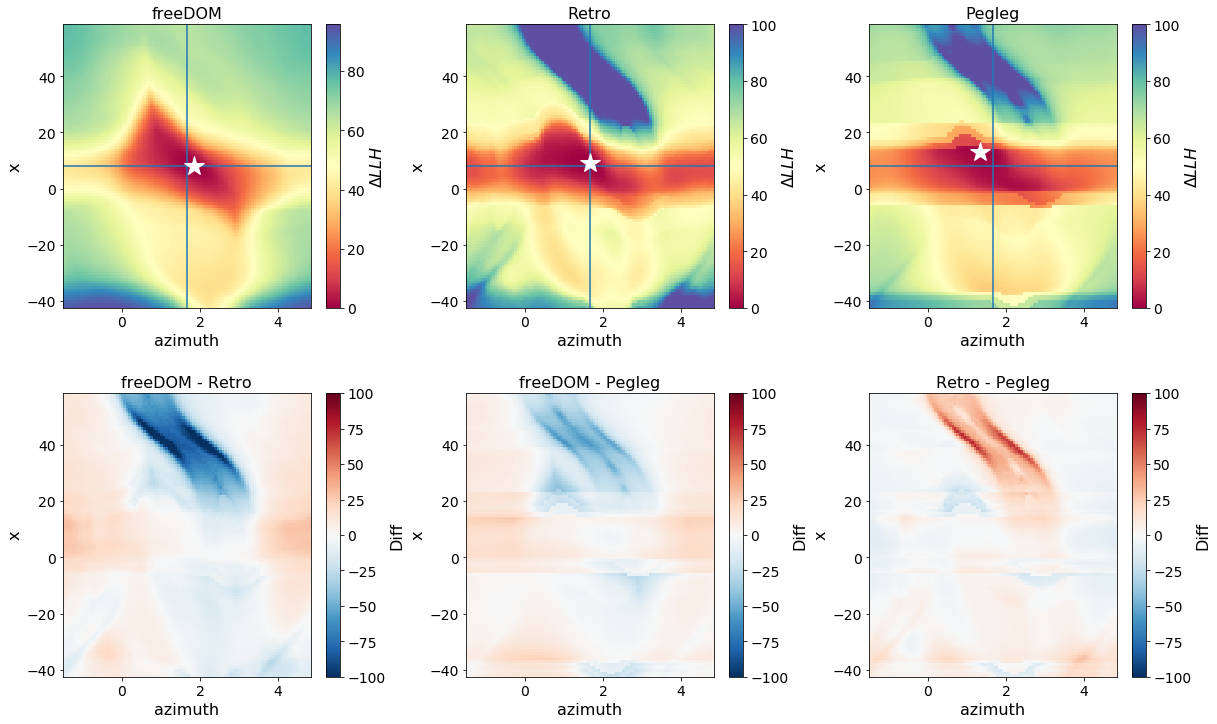

In [14]:
fig, ax = plt.subplots(2,3, figsize = (20, 12))

plt.subplots_adjust(hspace=0.3, wspace=0.3)

max_llh = 100

plot_2d(np.clip(p['tot'], 0, max_llh), t, ax[0,0])
ax[0,0].set_title('freeDOM')
plot_2d(np.clip(p['retro_llh'], 0, max_llh), t, ax[0,1])
ax[0,1].set_title('Retro')
plot_2d(np.clip(p['pegleg_llh'], 0, max_llh), t, ax[0,2])
ax[0,2].set_title('Pegleg')

np.clip(p['tot'] - p['retro_llh'], -max_llh, max_llh).plot(ax=ax[1,0], cmap='RdBu_r', cbar=True, vmin=-max_llh, vmax=max_llh, label='Diff')
ax[1,0].set_title('freeDOM - Retro')
np.clip(p['tot'] - p['pegleg_llh'], -max_llh, max_llh).plot(ax=ax[1,1], cmap='RdBu_r', cbar=True, vmin=-max_llh, vmax=max_llh, label='Diff')
ax[1,1].set_title('freeDOM - Pegleg')
np.clip(p['retro_llh'] - p['pegleg_llh'], -max_llh, max_llh).plot(ax=ax[1,2], cmap='RdBu_r', cbar=True, vmin=-max_llh, vmax=max_llh, label='Diff')
ax[1,2].set_title('Retro - Pegleg')

plt.savefig('plots/Event_%i_comparison_%s.png'%(event_idx, x_dim+y_dim), dpi=150, bbox_inches='tight')

CPU times: user 23min 54s, sys: 38.5 s, total: 24min 32s
Wall time: 23min 31s


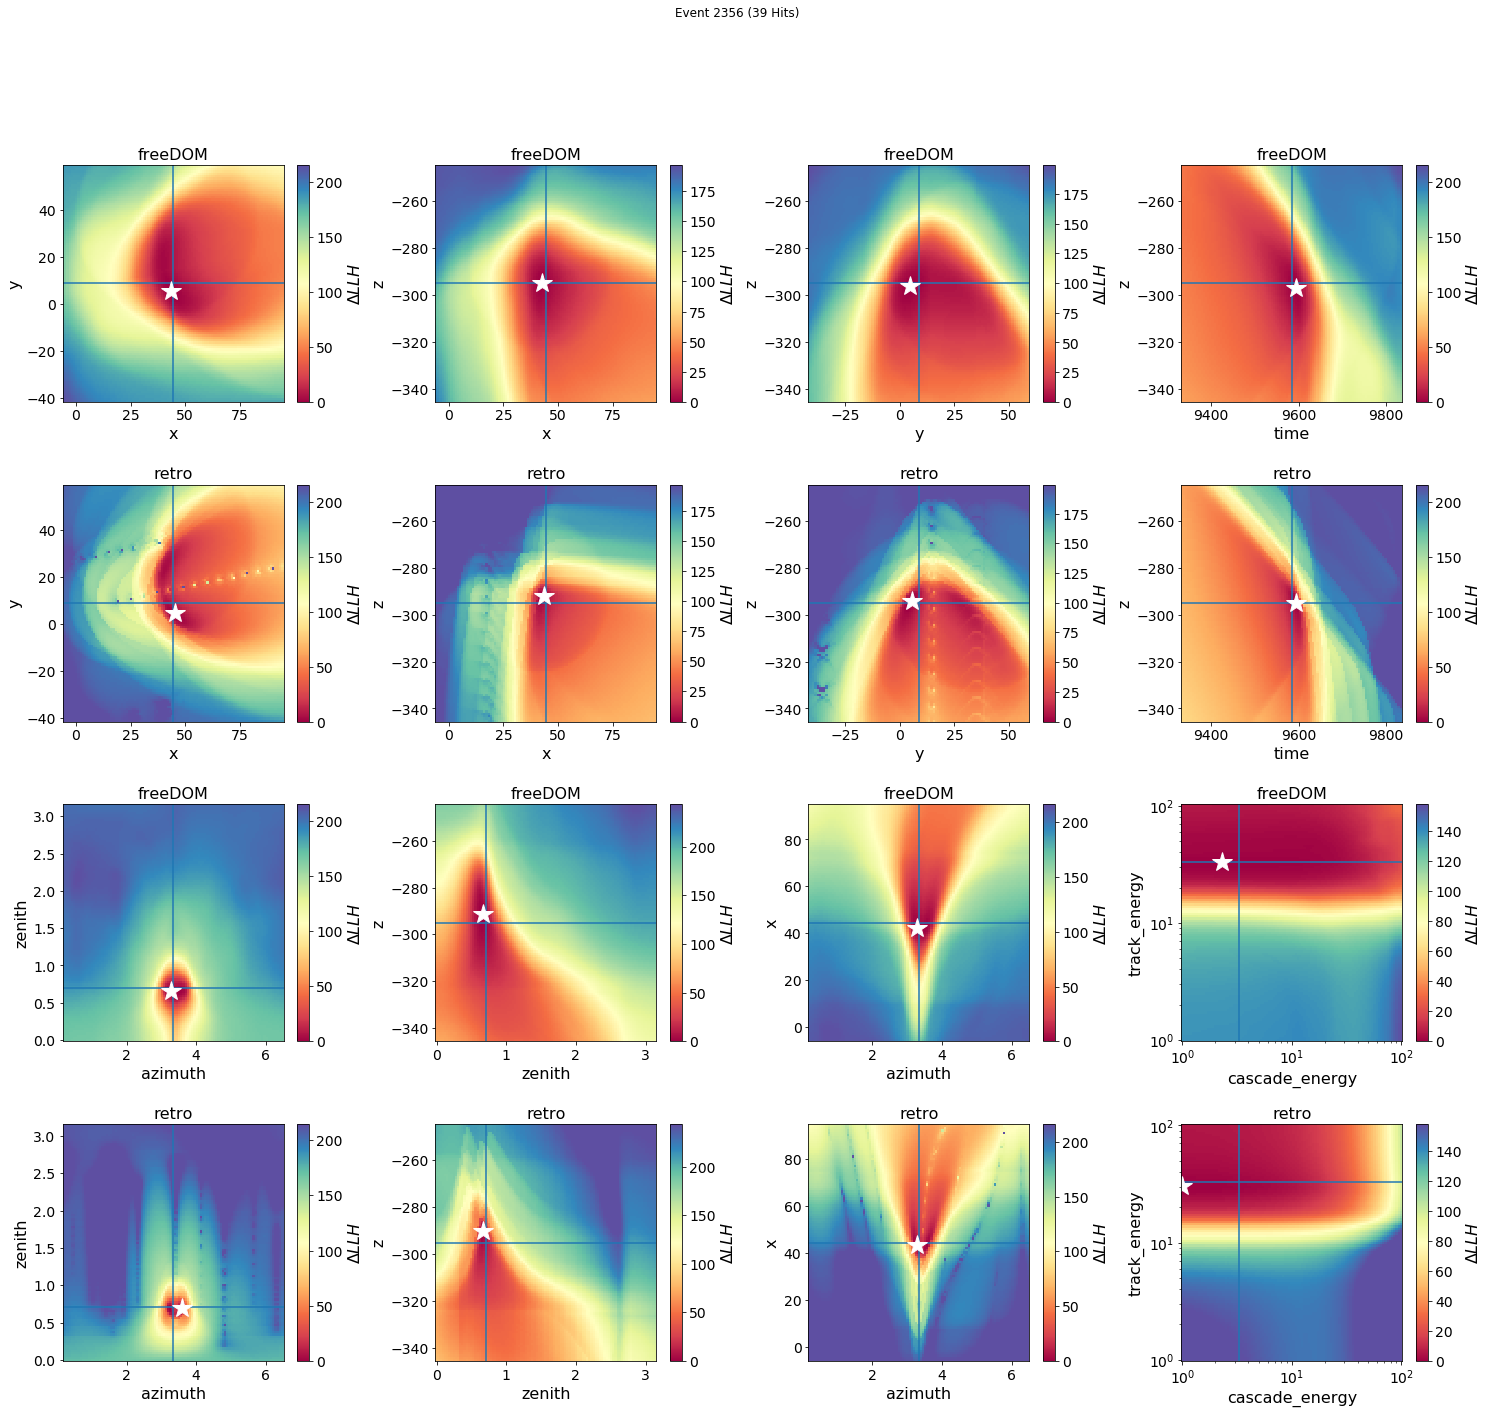

In [140]:
%%time
#event_idx = 666 # 666 #4242
event_idx = np.random.randint(0, len(events)-1) #12321 #1657
event_idx = 2522
#event_idx = 2840
#event_idx = 1127
#event_idx = 991
#event_idx = 1232
event_idx = 2356

event = events[event_idx]

width = 'tight'

fig, ax = plt.subplots(4, 4, figsize=(25, 22))
plt.subplots_adjust(wspace=0.35)
plt.subplots_adjust(hspace=0.35)



def double_plot(x, y, ax, retro_ax):
    p, t = get_llh_2d(event, x, y, n_steps=101, width=width)
    #p['retro_llh'] = np.clip(p['retro_llh'], 0, np.max(p['q_llh']))
    plot_2d(p['tot'], t, ax)
    ax.set_title('freeDOM')
    plot_2d(np.clip(p['retro_llh'], 0, np.max(p['tot'])), t, retro_ax)
    retro_ax.set_title('retro')
    
double_plot('x', 'y', ax[0,0], ax[1,0])
double_plot('x', 'z', ax[0,1], ax[1,1])
double_plot('y', 'z', ax[0,2], ax[1,2])
double_plot('time', 'z', ax[0,3], ax[1,3])
double_plot('azimuth', 'zenith', ax[2,0], ax[3,0])
double_plot('zenith', 'z', ax[2,1], ax[3,1])
double_plot('azimuth', 'x', ax[2,2], ax[3,2])
double_plot('cascade_energy', 'track_energy', ax[2,3], ax[3,3])

fig.suptitle('Event %i (%i Hits)'%(event_idx,event['hits'].shape[0]))
plt.savefig('plots/Comparison_Event_%i_%s.png'%(event_idx, width), dpi=300, bbox_inches='tight')

CPU times: user 26.6 s, sys: 36.1 s, total: 1min 2s
Wall time: 3.18 s


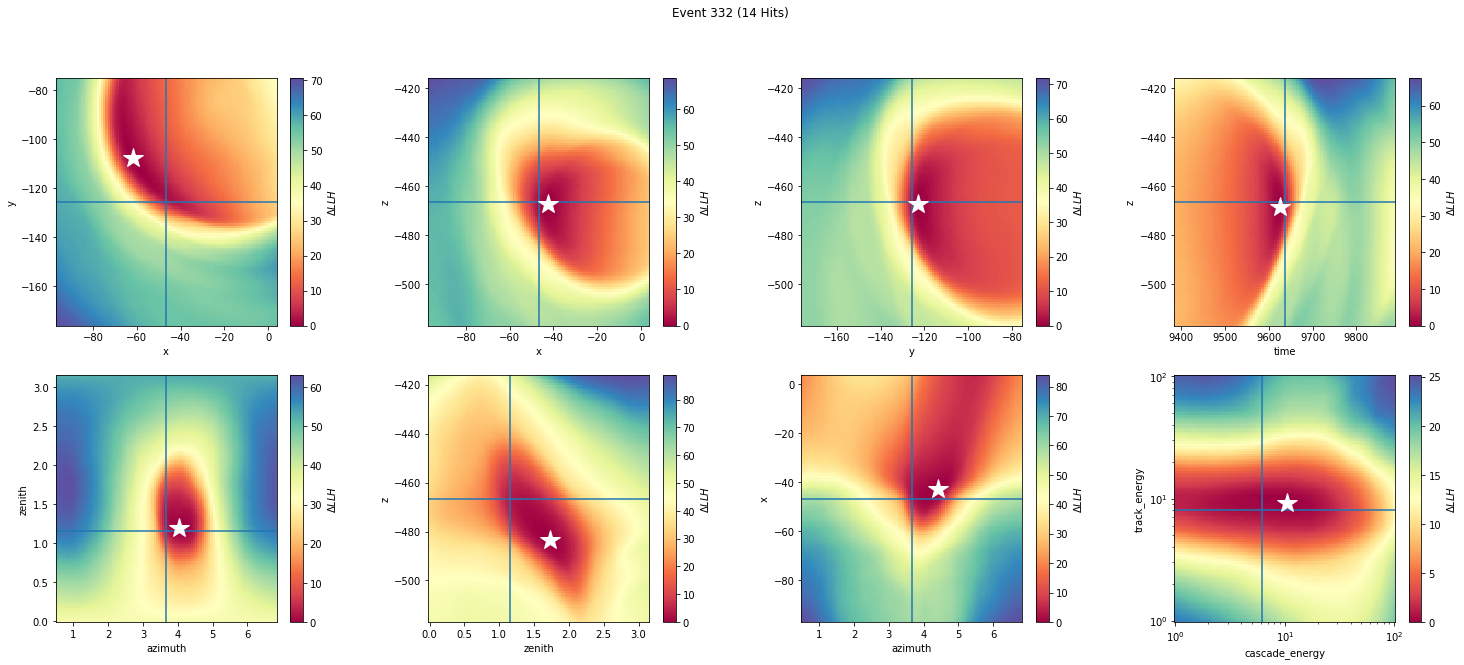

In [29]:
%%time
#event_idx = 666 # 666 #4242
event_idx = np.random.randint(0, len(events)-1) #12321 #1657
#event_idx = 2522
#event_idx = 969
#event_idx = 2840
#event_idx = 1127
#event_idx = 991
#event_idx = 1232
#event_idx = 2734 # many hits
#event_idx = 2770 # many hits
#event_idx = 2295
#event_idx = 2104
#event_idx = 319 # sharp
#event_idx = 2356 # pretty

event = events[event_idx]

width = 'tight'

fig, ax = plt.subplots(2, 4, figsize=(25, 10))
plt.subplots_adjust(wspace=0.35)

def plot(x, y, ax):
    p, t = get_llh_2d(event, x, y, n_steps=101, width=width, do_retro=False)
    #p['retro_llh'] = np.clip(p['retro_llh'], 0, np.max(p['q_llh']))
    plot_2d(p['tot'], t, ax)
    
plot('x', 'y', ax[0,0])
plot('x', 'z', ax[0,1])
plot('y', 'z', ax[0,2])
plot('time', 'z', ax[0,3])
plot('azimuth', 'zenith', ax[1,0])
plot('zenith', 'z', ax[1,1])
plot('azimuth', 'x', ax[1,2])
plot('cascade_energy', 'track_energy', ax[1,3])

fig.suptitle('Event %i (%i Hits)'%(event_idx,event['hits'].shape[0]))
plt.savefig('plots/Event_%i_%s.png'%(event_idx, width), dpi=150, bbox_inches='tight')

In [87]:
event = events[2770]
p, t = get_llh_2d(event, 'x', 'y', n_steps=301, width='tight', do_retro=False)

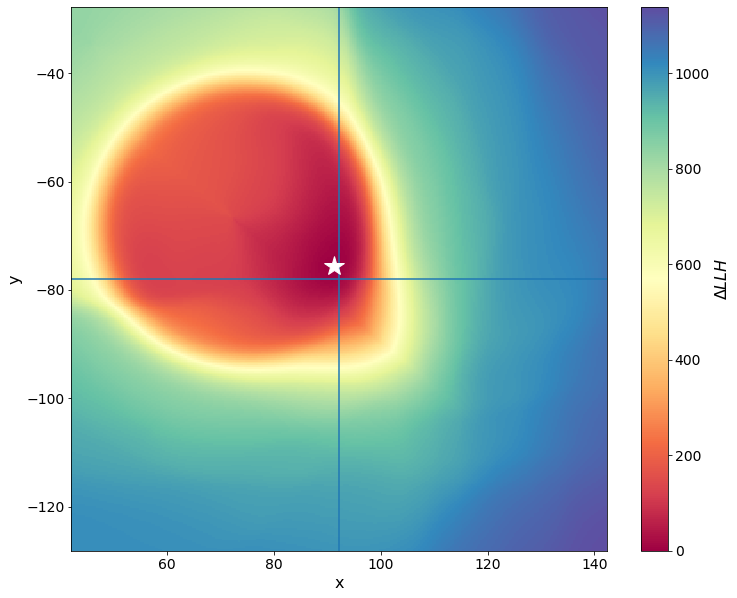

In [88]:
fig, ax = plt.subplots(1, 1, figsize=(12,10))
plot_2d(p['llh'], t, ax)

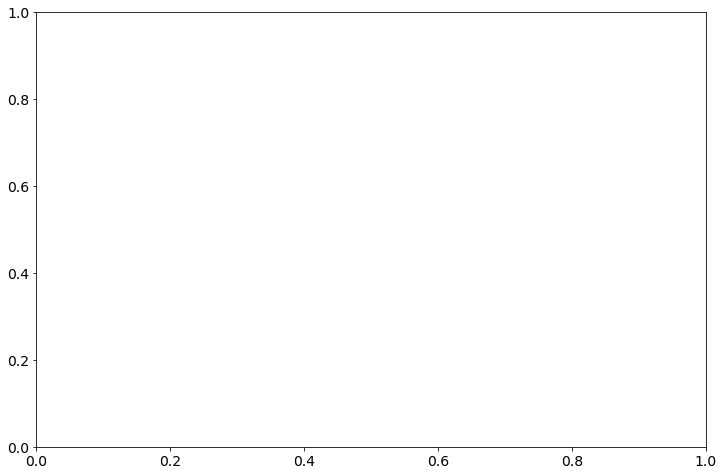

In [70]:
ani.save('plots/time.gif', writer='imagemagick', fps=25)

In [16]:
n_hits = np.array([event['hits'].shape[0] for event in events])

In [36]:
np.argsort(n_hits)[::-1][10:30]

array([2723, 2849, 2890, 2868, 2830, 2847, 2802, 2771, 2734, 2834, 2759,
       2711, 2836, 2770, 2918, 2904, 2680, 2902, 2888, 2691])

In [46]:
events[2770]['params'][6:8]

array([66.52249 , 84.483505], dtype=float32)

In [145]:
def get_llh_1d(event, plot_dim, n_steps=100, subtract=True):

    plot_idx = labels.index(plot_dim)
    true_p = event['params'][plot_idx]

    if plot_dim == 'zenith':
        xs = np.linspace(0, np.pi, n_steps)
    elif plot_dim == 'azimuth':
        xs = np.linspace(true_p - np.pi, true_p + np.pi, n_steps)
    elif 'energy' in plot_dim:
        #xs = np.linspace(0, min(max(10, 10*true_p), 1000), n_steps)
        xs = np.logspace(0,2, n_steps)
    else:
        delta = 50
        if plot_dim == 'time':
            delta *= 5
        xs = np.linspace(true_p-delta, true_p+delta, n_steps)    

    params = np.repeat(event['params'][np.newaxis, :], repeats=n_steps, axis=0)#.reshape(-1, 2)
    params[:, plot_idx] = xs
    
    
    total_llh, q_llh, all_hits, llhs  = freedom_llh(event, params)
    if subtract:
        total_llh -= np.min(total_llh)
        q_llh -= np.min(q_llh)
        all_hits -= np.min(all_hits)
        llhs -= np.min(llhs, axis=0)
    
    return xs, (total_llh, q_llh, all_hits, llhs)

In [3]:
# import pickle

# with open('test_data/test_events.pkl', 'wb') as f:
#     pickle.dump(events, f, protocol=pickle.HIGHEST_PROTOCOL)

#with open('test_data/test_event.pkl', 'rb') as f:
#    event = pickle.load(f)

In [147]:
def plot_llh(event, plot_dim, ax, n_steps=100):
    n_hits = event['hits'].shape[0]
    
    colors = plt.cm.Wistia(np.linspace(0,1,n_hits))
    plot_idx = labels.index(plot_dim)

    xs, (total_llh, q_llh, all_hits, llhs) = get_llh_1d(event, plot_dim, n_steps=n_steps)
        
    for i in range(n_hits):
        label = 'Single Hit' if i == n_hits//2 else None
        ax.plot(xs, llhs[:,i] - np.min(llhs[:,i]), c=colors[i], alpha=0.8, label=label)
    
    ax.axvline(event['params'][plot_idx], c='r', label='truth')
    ax.plot(xs, all_hits, c='deepskyblue', ls='-', lw=2, label='All Hits')
    ax.plot(xs, q_llh, c='green', lw=2, label='Charge')
    ax.plot(xs, total_llh, c='k', lw=2, label='Total')
    ax.axvline(xs[np.argmin(total_llh)], c='k', ls='--', label='Minimum')
    if 'energy' in plot_dim:
        ax.set_xscale('log')
    
    ax.set_xlabel(plot_dim)
    #plt.legend()

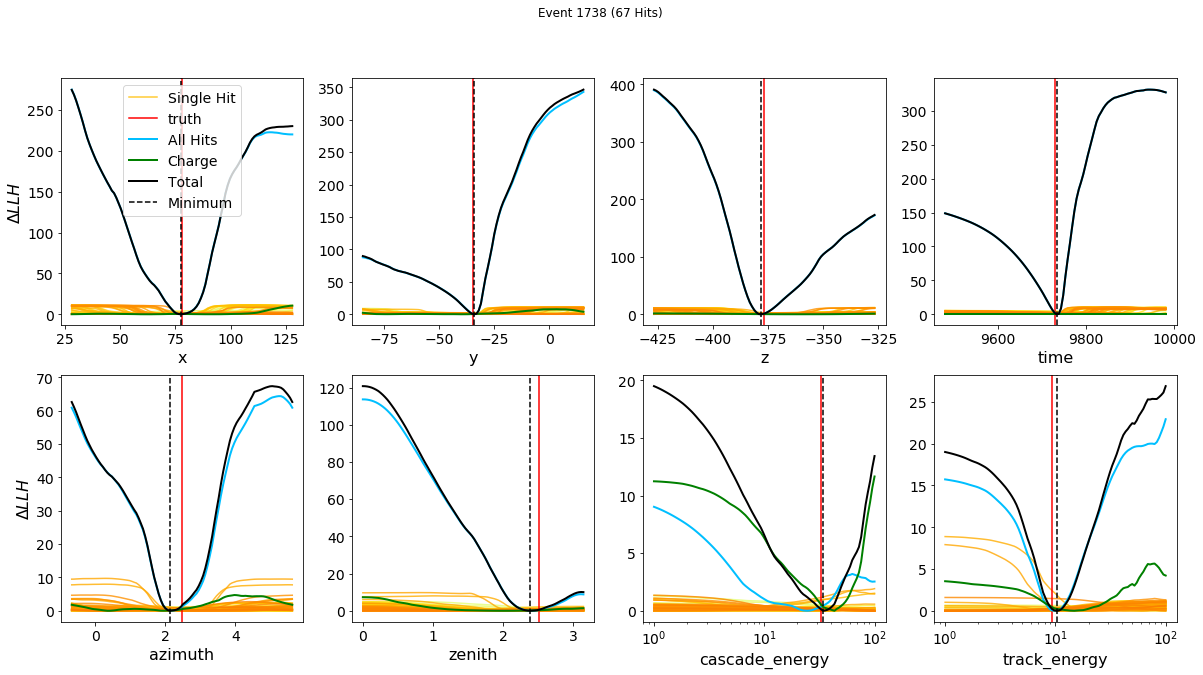

In [148]:
fig, ax = plt.subplots(2, 4, figsize=(20, 10)) #, sharey=True)

for i in range(ax.size):

    axis = ax[i//4, i%4]

    
    if i >= len(labels):
        axis.set_axis_off()
        continue
    
    #evt = 1756 
    #event_idx = 1111 #1126 #2274 #2244 #1930
    event_idx = np.random.randint(0, len(events)-1)
    event_idx = 1738
    #event_idx = 2840
    
    event = events[event_idx]
    #evt = 1756
    #evt = 12561
    
    
    plot_llh(event, labels[i], axis, n_steps=100) #1756, 987
    
    if i == 0:
        axis.legend()
        
        
    if i%4 == 0:
        axis.set_ylabel(r'$\Delta LLH$')

        
fig.suptitle('Event %i (%i Hits)'%(event_idx,event['hits'].shape[0]))
        
plt.savefig('plots/hitnet_event%i.png'%event_idx, dpi=300, bbox_inches='tight')

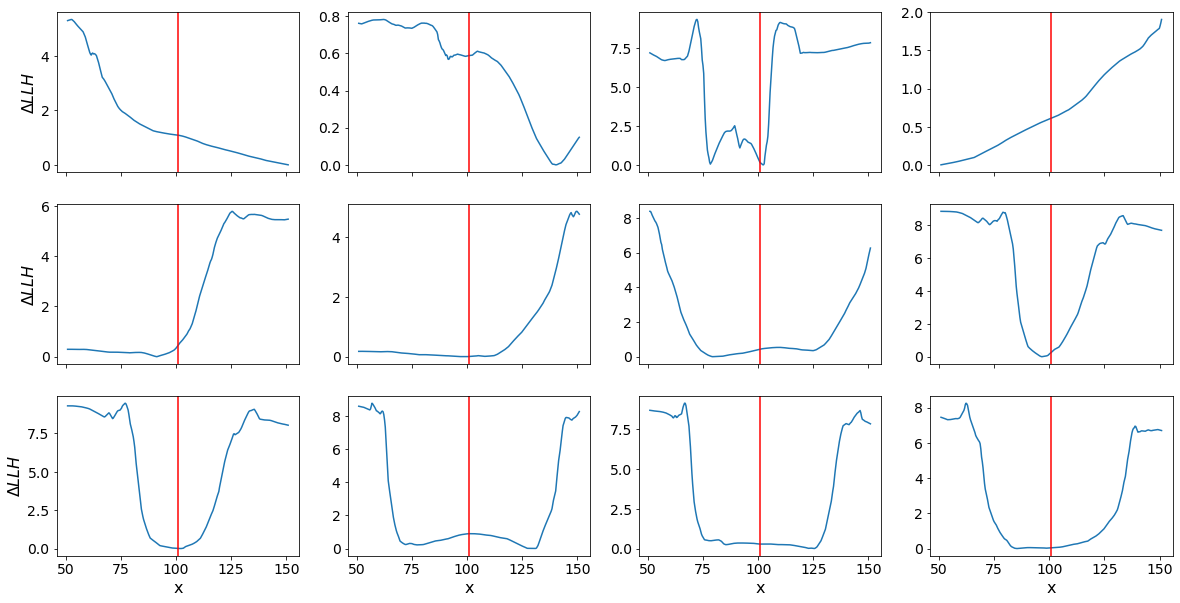

In [218]:
fig, ax = plt.subplots(3, 4, figsize=(20, 10), sharex=True)

event = events[1111]

n_hits = event['hits'].shape[0]

#colors = plt.cm.Wistia(np.linspace(0,1,n_hits))

plot_dim = 'x'
plot_idx = labels.index(plot_dim)


xs, (total_llh, q_llh, all_hits, llhs) = get_llh_1d(event, plot_dim, n_steps=300)


for i in range(n_hits):
    axis = ax[i//4, i%4]
    label = 'Single Hit' if i == n_hits//2 else None
    axis.plot(xs, llhs[:,i] - np.min(llhs[:,i]), label=label)

    axis.axvline(event['params'][plot_idx], c='r', label='truth')
    if i%4 == 0:
        axis.set_ylabel(r'$\Delta LLH$')
    if i//4 == 2:
        axis.set_xlabel(plot_dim)

plt.savefig('plots/Single_hits_%i.png'%event_idx, dpi=300, bbox_inches='tight')        
# ax.plot(xs, all_hits, c='deepskyblue', ls='-', lw=2, label='All Hits')
# ax.plot(xs, q_llh, c='green', lw=2, label='Charge')
# ax.plot(xs, total_llh, c='k', lw=2, label='Total')
# ax.axvline(xs[np.argmin(total_llh)], c='k', ls='--', label='Minimum')
# if 'energy' in plot_dim:
#     ax.set_xscale('log')

# ax.set_xlabel(plot_dim)
# #plt.legend()

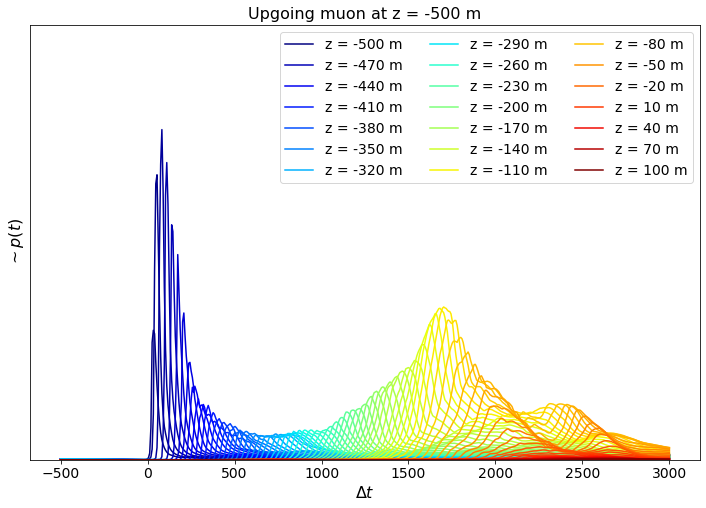

In [240]:
N = 81

colors = plt.cm.jet(np.linspace(0,1,N))

fig, ax = plt.subplots(1,1)

def animate(muon_z):

    ax.clear()

    for i, z in enumerate(np.linspace(-500, 100, N)):

        params = np.repeat(np.array([0., 0., muon_z, 0, 0., np.pi, 20., 100.]), 500).reshape(8, -1).T

        params[:, 3] = np.linspace(-3000, 500, params.shape[0])
        
        event = {}
        event['hits'] = np.array([[5.,5., z, 0., 1.]])
        event['total_charge'] = 1.

        _, _, l, _, = freedom_llh(event, params)
        if int(z)%10 == 0:
            label = 'z = %.0f m'%z
        else:
            label = None

        ax.plot(-params[:, 3], np.exp(-l), color=colors[i], label=label)
    ax.legend(ncol=3, loc='upper right')
    ax.get_yaxis().set_ticks([])
    ax.set_ylim(0,300)
    ax.set_title(f'Upgoing muon at z = {muon_z:.0f} m')
    ax.set_xlabel(r'$\Delta t$')
    ax.set_ylabel(r'$\sim p(t)$')
        
    
ani = animation.FuncAnimation(fig, animate, frames=np.linspace(-500, -200, 100))


#plt.gca().set_yscale('log')
#plt.savefig('upgoing_muon.png')

In [136]:
ani.save('plots/muon.gif', writer='imagemagick', fps=25)

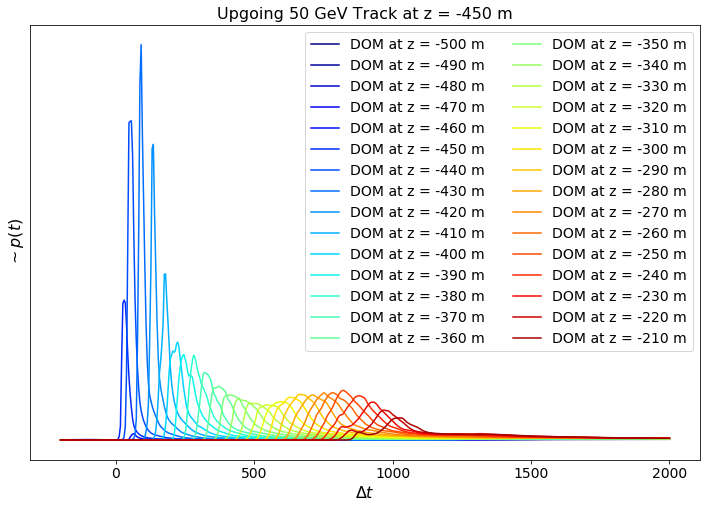

In [241]:
N = 31


colors = plt.cm.jet(np.linspace(0,1,N))

for i, z in enumerate(np.linspace(-500, -200, N)[:-1]):

    params = np.repeat(np.array([0., 0., -450., 0, 0., np.pi, 0., 50.]), 500).reshape(8, -1).T
    #params = np.repeat(np.array([0., 0., -450., 0, 0., np.pi, 50., 0.]), 500).reshape(8, -1).T


    params[:, 3] = np.linspace(-2000, 200, params.shape[0])
    
    event = {}
    event['hits'] = np.array([[5.,5., z, 0., 1.]])
    event['total_charge'] = 1.


    _, _, l, _, = freedom_llh(event, params)

    plt.plot(-params[:, 3], np.exp(-l), color=colors[i], label='DOM at z = %.0f m'%z)
plt.legend(ncol=2)
#plt.gca().set_ylim(0,500)
plt.gca().get_yaxis().set_ticks([])
plt.gca().set_title('Upgoing 50 GeV Track at z = %.0f m'%params[0,2])
plt.gca().set_xlabel(r'$\Delta t$')
plt.gca().set_ylabel(r'$\sim p(t)$')
#plt.gca().set_yscale('log')
plt.savefig('plots/upgoing_track.png', dpi=300, bbox_inches='tight')

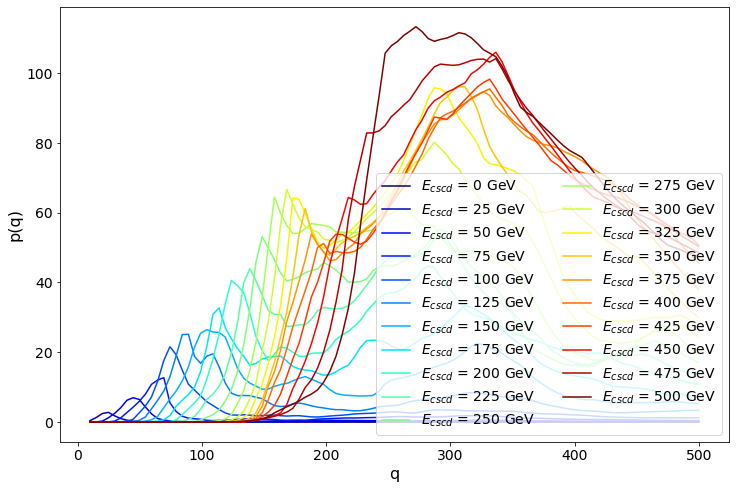

In [242]:
qs = []
N = 21

charges = np.linspace(10, 500, 100)
xs = np.logspace(0, 3, N)
xs = np.linspace(0, 500, N)

for charge in charges:
    params = np.repeat(np.array([0., 0., -300., 0, np.pi, 0, 0., 0.]), N).reshape(8, -1).T
    params[:, 6] = xs
    event = {}
    event['hits'] = np.array([])
    event['total_charge'] = charge
    _, q, l, _, = freedom_llh(event, params)
    qs.append(q)

qs = np.array(qs)

colors = plt.cm.jet(np.linspace(0,1,len(xs)))

for i in range(len(xs)):
    q = qs[:,i]
    #q -= np.min(q)
    plt.plot(charges, np.exp(-q), color = colors[i], label=r'$E_{cscd}$ = %i GeV'%xs[i]);
    
plt.gca().set_xlabel('q')
plt.gca().set_ylabel('p(q)')
plt.legend(loc="lower right", ncol=2)

In [45]:
geo = np.load('geo_array.npy')

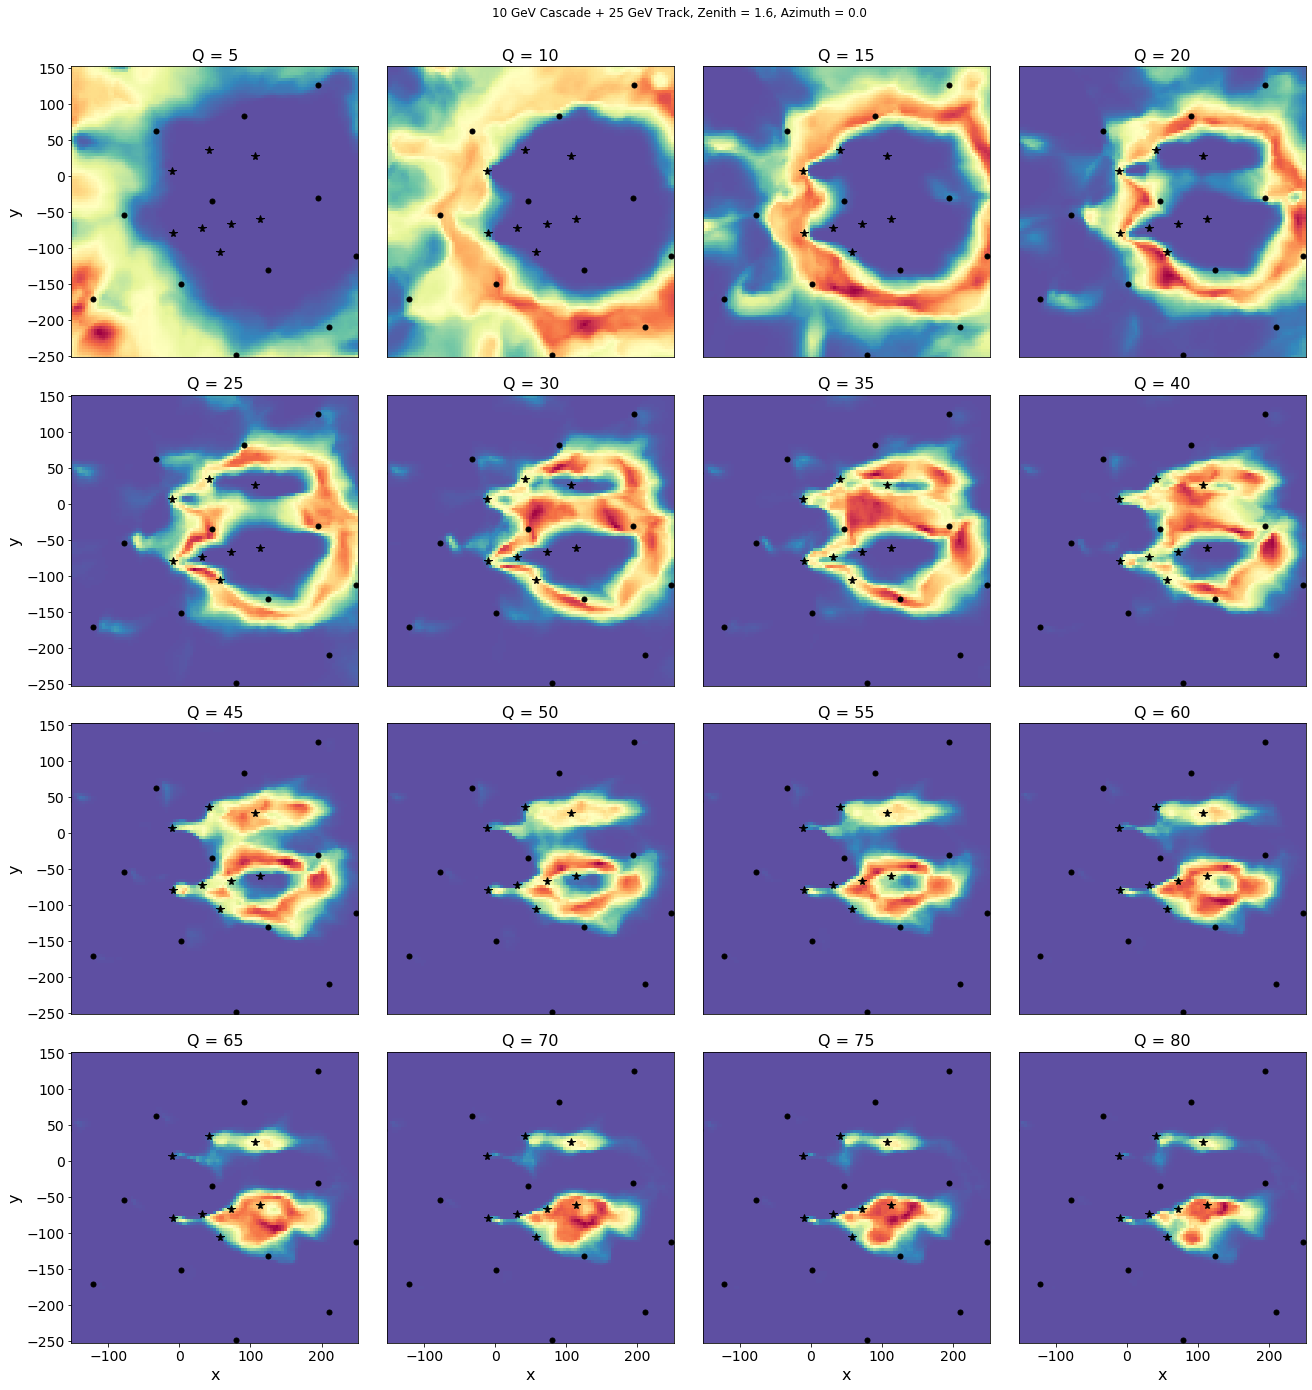

In [46]:
fig, ax = plt.subplots(4, 4, figsize=(18, 20))

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.subplots_adjust(wspace=0.1)

N = 101

charges = np.linspace(5, 80, 16)


def animate(az):

    for i in range(len(charges)):

        g = dm.GridData(x = np.linspace(-150, 250, N), y= np.linspace(-250, 150, N))

        par = np.array([0., 0., -360., 0, az, np.pi/2., 10., 25.])

        params = np.repeat(par, N*N).reshape(8, -1).T
        params[:, 0] = g['x'].flatten()
        params[:, 1] = g['y'].flatten()
        event = {}
        event['hits'] = np.array([])
        event['total_charge'] = charges[i]
        _, q, l, _, = freedom_llh(event, params)


        g['q'] = q.reshape(g.grid.shape)
        g['p'] = np.clip(np.exp(-g['q']), 0, 100)

        axis = ax[i//4, i%4]

        axis.clear()

        g.plot('p', cmap='Spectral_r', ax=axis) #, cbar=True)
        axis.set_title('Q = %.0f'%charges[i])

        if not i//4 == 3:
            axis.get_xaxis().set_visible(False)
        if i%4:
            axis.get_yaxis().set_visible(False)



        axis.plot(geo[:78, 0, 0], geo[:78, 0, 1], 'o', color='k', ms=5)
        axis.plot(geo[78:, 0, 0], geo[78:, 0, 1], '*', color='k', ms=8)
        
        fig.suptitle(f'{par[6]:.0f} GeV Cascade + {par[7]:.0f} GeV Track, Zenith = {par[5]:.1f}, Azimuth = {par[4]:.1f}')
        
#plt.savefig('cascade_25GeV.png')

ani = animation.FuncAnimation(fig, animate, frames=np.linspace(0, 2*np.pi, 50))


In [250]:
ani.save('plots/test.gif', writer='imagemagick', fps=25)

<Figure size 864x576 with 0 Axes>

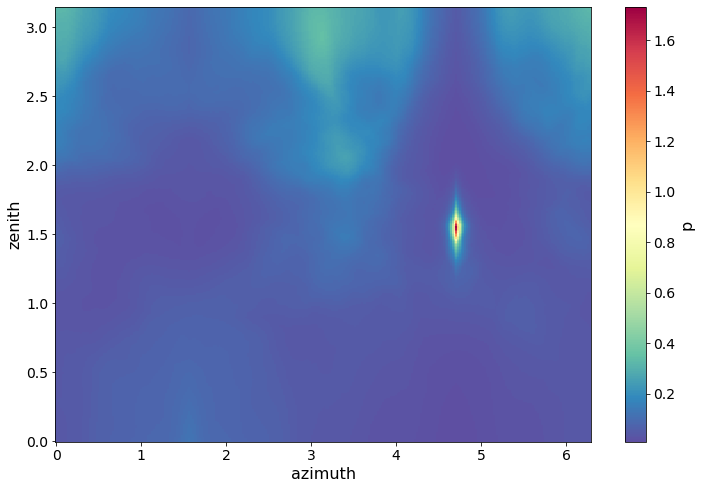

In [253]:
N = 301

g = dm.GridData(azimuth = np.linspace(0, 2*np.pi, N), zenith= np.linspace(0, np.pi, N))

par = np.array([0., 0., -250., 0,0, 0, 20., 20.])

params = np.repeat(par, N*N).reshape(8, -1).T
params[:, 4] = g['azimuth'].flatten()
params[:, 5] = g['zenith'].flatten()
event = {}
event['hits'] = np.array([[0.,20., -250, 50., 1.]])
event['total_charge'] = 1.
_, q, l, _, = freedom_llh(event, params)

g['l'] = l.reshape(g.grid.shape)
g['p'] = np.exp(-g['l'])


g.plot('p', cmap='Spectral_r', cbar=True)
    

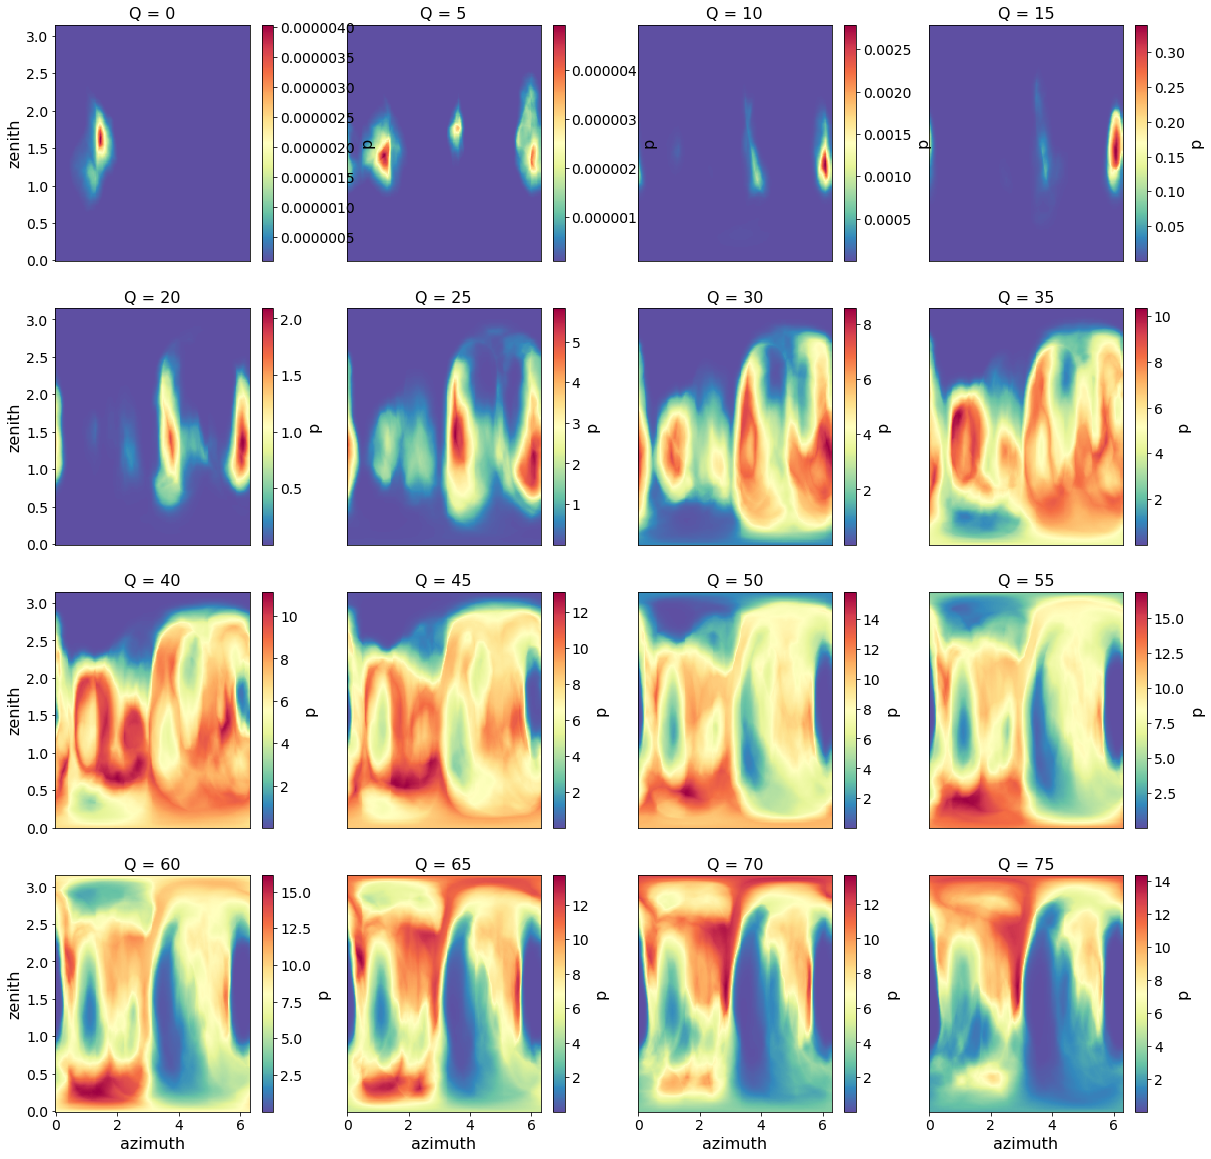

In [47]:
fig, ax = plt.subplots(4, 4, figsize=(20, 20))


N = 201

charges = np.linspace(0, 75, 16)


for i in range(len(charges)):
    
    g = dm.GridData(azimuth = np.linspace(0, 2*np.pi, N), zenith= np.linspace(0, np.pi, N))

    par = np.array([50., -50., -350., 0,0, 0, 0., 50.])

    params = np.repeat(par, N*N).reshape(8, -1).T
    params[:, 4] = g['azimuth'].flatten()
    params[:, 5] = g['zenith'].flatten()
    event = {}
    event['hits'] = np.array([])
    event['total_charge'] = charges[i]
    _, q, l, _, = freedom_llh(event, params)

    g['q'] = q.reshape(g.grid.shape)
    g['p'] = np.exp(-g['q'])

    axis = ax[i//4, i%4]
    
    g.plot('p', cmap='Spectral_r', ax=axis, cbar=True)
    axis.set_title('Q = %.0f'%charges[i])
    
    if not i//4 == 3:
        axis.get_xaxis().set_visible(False)
    if i%4:
        axis.get_yaxis().set_visible(False)
        
    
    
    #axis.plot(geo[:78, 0, 0], geo[:78, 0, 1], 'o', color='k', ms=5)
    #axis.plot(geo[78:, 0, 0], geo[78:, 0, 1], '*', color='k', ms=8)
        
#plt.savefig('cascade_25GeV.png')